## Development notebook!

**A newer version of this training script is impleneted in `src/train.py`**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, SequentialSampler
import pandas as pd
import numpy as np
import os
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold, KFold
import gc
import wandb

In [2]:
print("Torch v" + torch.__version__)
print("Numpy v" + np.__version__)

Torch v2.0.1
Numpy v1.23.5


In [3]:
train_terms = pd.read_csv("../input/cafa-5-protein-function-prediction/Train/train_terms.tsv",sep="\t")
print(train_terms.shape)

(5363863, 3)


In [4]:
train_terms.head()

,EntryID,term,aspect
0,A0A009IHW8,GO:0008152,BPO
1,A0A009IHW8,GO:0034655,BPO
2,A0A009IHW8,GO:0072523,BPO
3,A0A009IHW8,GO:0044270,BPO
4,A0A009IHW8,GO:0006753,BPO


In [5]:
term_aspect_map = train_terms.set_index('term')['aspect'].to_dict()
len(term_aspect_map), term_aspect_map['GO:0008152']

(31466, 'BPO')

In [6]:
train_protein_ids = np.load('../input/t5embeds/train_ids.npy')
print(train_protein_ids.shape)

(142246,)


In [7]:
train_protein_ids[:10]

array(['P20536', 'O73864', 'O95231', 'A0A0B4J1F4', 'P54366', 'P33681',
       'P77596', 'Q16787', 'Q59VP0', 'P13508'], dtype='<U10')

In [8]:
train_embeddings = np.load('../input/t5embeds/train_embeds.npy')

# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = train_embeddings.shape[1]
train_df = pd.DataFrame(train_embeddings, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
print(train_df.shape)

(142246, 1024)


In [9]:
train_df.head()

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,...,Column_1015,Column_1016,Column_1017,Column_1018,Column_1019,Column_1020,Column_1021,Column_1022,Column_1023,Column_1024
0,0.049488,-0.032935,0.032473,-0.033723,-0.059505,0.075936,-0.045860,-0.104476,-0.072112,0.038806,...,-0.046516,-0.028773,-0.021878,-0.097883,0.056475,0.080950,-0.020938,-0.043532,0.096463,0.073070
1,-0.044616,0.064925,-0.080263,-0.075338,-0.004731,0.025408,-0.024685,-0.016568,-0.038980,-0.033870,...,-0.040173,0.003925,0.006130,0.007362,-0.066848,0.106882,-0.030134,0.026724,0.027879,-0.048430
2,-0.020128,-0.049779,0.007894,-0.000829,-0.047737,0.086453,-0.038107,-0.036379,0.029611,0.045029,...,0.029388,0.008456,0.000697,0.013502,-0.005968,-0.011571,0.005704,-0.036103,0.007693,0.106234
3,-0.007515,0.060628,0.004045,0.027056,-0.021542,0.010380,-0.025064,-0.055834,0.068238,0.027764,...,0.020792,0.023307,0.009009,0.018211,0.020820,-0.031738,0.013279,-0.018357,0.008087,0.010917
4,0.013468,0.041516,0.018435,-0.035595,0.008770,0.018699,-0.015452,-0.038092,-0.038326,-0.012299,...,-0.044742,-0.025432,-0.060886,-0.026915,0.026342,0.017237,0.014731,-0.016861,-0.016272,0.037054


In [10]:
# Set the limit for label
num_of_labels = 1500

labels_to_consider = train_terms['term'].value_counts().index[:num_of_labels].tolist()

## Prepare dataset

You may skip this step if you have created the dataset before.

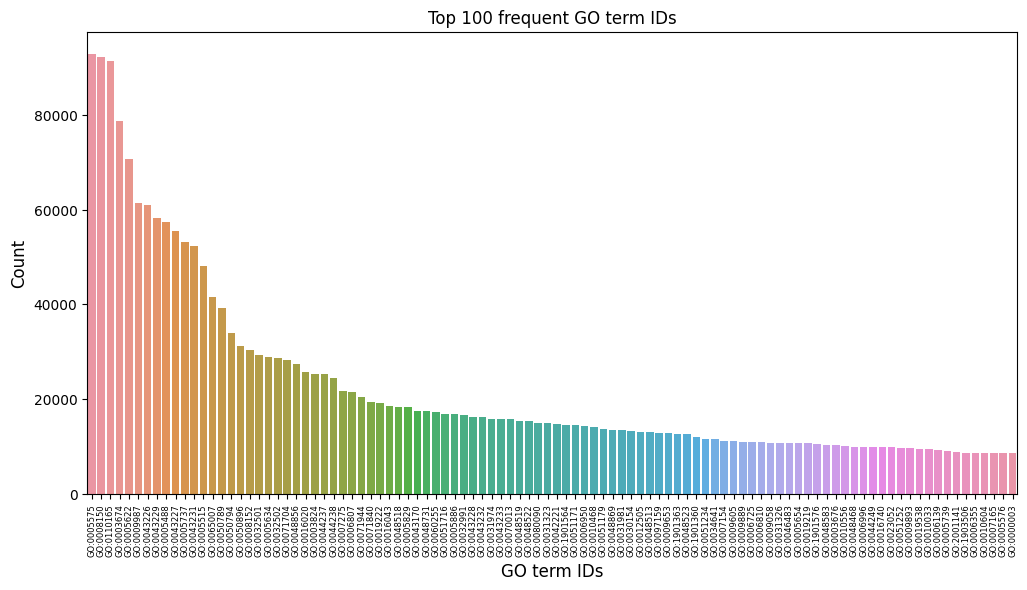

In [28]:
# Select first 1500 values for plotting
plot_df = train_terms['term'].value_counts().iloc[:100]

figure, axis = plt.subplots(1, 1, figsize=(12, 6))

bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values)
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size = 6)
axis.set_title('Top 100 frequent GO term IDs')
bp.set_xlabel("GO term IDs", fontsize = 12)
bp.set_ylabel("Count", fontsize = 12)
plt.show()

In [29]:
# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_terms['term'].value_counts().index[:num_of_labels].tolist()

In [30]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_terms.loc[train_terms['term'].isin(labels)]

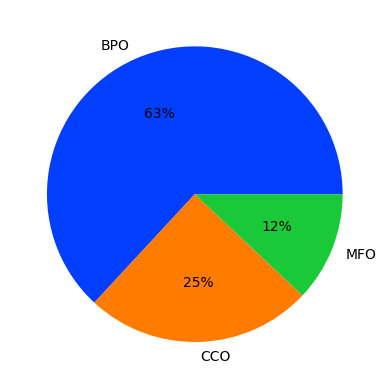

In [23]:
pie_df = train_terms_updated['aspect'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [15]:
# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = train_protein_ids.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each label
for i in tqdm(range(num_of_labels), total=num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['term'] ==  labels[i]]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

# Convert train_Y numpy into pandas dataframe
labels_df = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df.shape)

  0%|          | 0/1500 [00:00<?, ?it/s]

(142246, 1500)


In [16]:
labels_df.head()

,GO:0005575,GO:0008150,GO:0110165,GO:0003674,GO:0005622,GO:0009987,GO:0043226,GO:0043229,GO:0005488,GO:0043227,...,GO:0034250,GO:0140053,GO:0031345,GO:0098802,GO:0045861,GO:0051783,GO:0031674,GO:0001818,GO:0006874,GO:0016887
0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
labels_df.to_csv(f'../output/t5_train_labels_num_lbl-{num_of_labels}.csv', index=False)

In [28]:
train_terms_updated.aspect.unique()

array(['BPO', 'CCO', 'MFO'], dtype=object)

In [30]:
train_size = train_protein_ids.shape[0] # len(X)
train_types = np.zeros((train_size ,3))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(train_protein_ids)

# Loop through each type
type_labels = ['BPO', 'CCO', 'MFO']
for i, t in enumerate(type_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['aspect'] ==  t]
    
    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    type_related_proteins = n_train_terms['EntryID'].unique()
    
    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_types[:,i] =  series_train_protein_ids.isin(type_related_proteins).astype(float)

# Convert train_Y numpy into pandas dataframe
types_df = pd.DataFrame(data = train_types, columns = type_labels)

# create maps for binary to column name
map_bpo = {0: '', 1: 'BPO'}
map_cco = {0: '', 1: 'CCO'}
map_mfo = {0: '', 1: 'MFO'}

# replace binary with column name and concatenate
types_df['combined'] = types_df['BPO'].map(map_bpo) + ',' + types_df['CCO'].map(map_cco) + ',' + types_df['MFO'].map(map_mfo)

# remove unnecessary leading, trailing, and multiple separators
types_df['combined'] = types_df['combined'].str.strip(',').str.replace(',+', ',', regex=True)

print(types_df.shape)

(142246, 4)


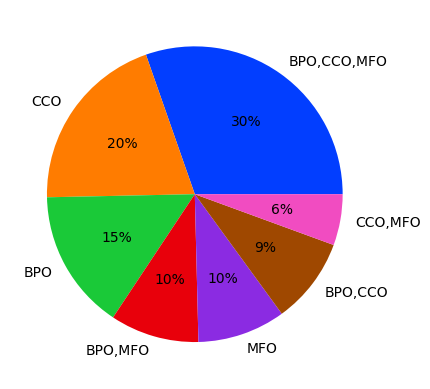

In [33]:
pie_df = types_df['combined'].value_counts()
palette_color = sns.color_palette('bright')
plt.pie(pie_df.values, labels=np.array(pie_df.index), colors=palette_color, autopct='%.0f%%')
plt.show()

In [34]:
types_df.to_csv(f'../output/train_types_in_num_lbl-{num_of_labels}.csv', index=False)

## Dataset checkpoint

In [11]:
labels_df = pd.read_csv(f'../output/t5_train_labels_num_lbl-{num_of_labels}.csv')

In [12]:
types_df = pd.read_csv(f'../output/train_types_in_num_lbl-{num_of_labels}.csv')

## Metrics

In [13]:
import numpy as np
import pandas as pd
import multiprocessing as mp
import copy
import logging

class Graph:
    """
    Ontology class. One ontology == one namespace
    DAG is the adjacence matrix (sparse) which represent a Directed Acyclic Graph where
    DAG(i,j) == 1 means that the go term i is_a (or is part_of) j
    Parents that are in a different namespace are discarded
    """
    def __init__(self, namespace, terms_dict, ia_dict=None, orphans=False):
        """
        terms_dict = {term: {name: , namespace: , def: , alt_id: , rel:}}
        """
        self.namespace = namespace
        self.dag = []  # [[], ...] terms (rows, axis 0) x parents (columns, axis 1)
        self.terms_dict = {}  # {term: {index: , name: , namespace: , def: }  used to assign term indexes in the gt
        self.terms_list = []  # [{id: term, name:, namespace: , def:, adg: [], children: []}, ...]
        self.idxs = None  # Number of terms
        self.order = None
        self.toi = None
        self.ia = None

        rel_list = []
        for self.idxs, (term_id, term) in enumerate(terms_dict.items()):
            rel_list.extend([[term_id, rel, term['namespace']] for rel in term['rel']])
            self.terms_list.append({'id': term_id, 'name': term['name'], 'namespace': namespace, 'def': term['def'],
                                 'adj': [], 'children': []})
            self.terms_dict[term_id] = {'index': self.idxs, 'name': term['name'], 'namespace': namespace, 'def': term['def']}
            for a_id in term['alt_id']:
                self.terms_dict[a_id] = copy.copy(self.terms_dict[term_id])
        self.idxs += 1

        self.dag = np.zeros((self.idxs, self.idxs), dtype='bool')

        # id1 term (row, axis 0), id2 parent (column, axis 1)
        for id1, id2, ns in rel_list:
            if self.terms_dict.get(id2):
                i = self.terms_dict[id1]['index']
                j = self.terms_dict[id2]['index']
                self.dag[i, j] = 1
                self.terms_list[i]['adj'].append(j)
                self.terms_list[j]['children'].append(i)
                logging.debug("i,j {},{} {},{}".format(i, j, id1, id2))
            else:
                logging.debug('Skipping branch to external namespace: {}'.format(id2))
        logging.debug("dag {}".format(self.dag))
        # Topological sorting
        self.top_sort()
        logging.debug("order sorted {}".format(self.order))

        if orphans:
            self.toi = np.arange(self.dag.shape[0])  # All terms, also those without parents
        else:
            self.toi = np.nonzero(self.dag.sum(axis=1) > 0)[0]  # Only terms with parents
        logging.debug("toi {}".format(self.toi))

        if ia_dict is not None:
            self.set_ia(ia_dict)

        return

    def top_sort(self):
        """
        Takes a sparse matrix representing a DAG and returns an array with nodes indexes in topological order
        https://en.wikipedia.org/wiki/Topological_sorting
        """
        indexes = []
        visited = 0
        (rows, cols) = self.dag.shape

        # create a vector containing the in-degree of each node
        in_degree = self.dag.sum(axis=0)
        # logging.debug("degree {}".format(in_degree))

        # find the nodes with in-degree 0 (leaves) and add them to the queue
        queue = np.nonzero(in_degree == 0)[0].tolist()
        # logging.debug("queue {}".format(queue))

        # for each element of the queue increment visits, add them to the list of ordered nodes
        # and decrease the in-degree of the neighbor nodes
        # and add them to the queue if they reach in-degree == 0
        while queue:
            visited += 1
            idx = queue.pop(0)
            indexes.append(idx)
            in_degree[idx] -= 1
            l = self.terms_list[idx]['adj']
            if len(l) > 0:
                for j in l:
                    in_degree[j] -= 1
                    if in_degree[j] == 0:
                        queue.append(j)

        # if visited is equal to the number of nodes in the graph then the sorting is complete
        # otherwise the graph can't be sorted with topological order
        if visited == rows:
            self.order = indexes
        else:
            raise Exception("The sparse matrix doesn't represent an acyclic graph")

    def set_ia(self, ia_dict):
        self.ia = np.zeros(self.idxs, dtype='float')
        for term_id in self.terms_dict:
            if ia_dict.get(term_id):
                self.ia[self.terms_dict[term_id]['index']] = ia_dict.get(term_id)
            else:
                logging.debug('Missing IA for term: {}'.format(term_id))
        # Convert inf to zero
        np.nan_to_num(self.ia, copy=False, nan=0, posinf=0, neginf=0)
        self.toi = np.nonzero(self.ia > 0)[0]


class Prediction:
    """
    The score matrix contains the scores given by the predictor for every node of the ontology
    """
    def __init__(self, ids, matrix, idx, namespace=None):
        self.ids = ids
        self.matrix = matrix  # scores
        self.next_idx = idx
        # self.n_pred_seq = idx + 1
        self.namespace = namespace

    def __str__(self):
        return "\n".join(["{}\t{}\t{}".format(index, self.matrix[index], self.namespace) for index, _id in enumerate(self.ids)])


class GroundTruth:
    def __init__(self, ids, matrix, namespace=None):
        self.ids = ids
        self.matrix = matrix
        self.namespace = namespace


def propagate(matrix, ont, order, mode='max'):
    """
    Update inplace the score matrix (proteins x terms) up to the root taking the max between children and parents
    """
    if matrix.shape[0] == 0:
        raise Exception("Empty matrix")

    deepest = np.where(np.sum(matrix[:, order], axis=0) > 0)[0][0]
    if deepest.size == 0:
        raise Exception("The matrix is empty")

    # Remove leaves
    order_ = np.delete(order, [range(0, deepest)])

    for i in order_:
        # Get direct children
        children = np.where(ont.dag[:, i] != 0)[0]
        if children.size > 0:
            cols = np.concatenate((children, [i]))
            if mode == 'max':
                matrix[:, i] = matrix[:, cols].max(axis=1)
            elif mode == 'fill':
                rows = np.where(matrix[:, i] == 0)[0]
                if rows.size:
                    idx = np.ix_(rows, cols)
                    matrix[rows, i] = matrix[idx].max(axis=1)[0]
    return


def obo_parser(obo_file, valid_rel=("is_a", "part_of")):
    """
    Parse a OBO file and returns a list of ontologies, one for each namespace.
    Obsolete terms are excluded as well as external namespaces.
    """
    term_dict = {}
    term_id = None
    namespace = None
    name = None
    term_def = None
    alt_id = []
    rel = []
    obsolete = True
    with open(obo_file) as f:
        for line in f:
            line = line.strip().split(": ")
            if line and len(line) > 1:
                k = line[0]
                v = ": ".join(line[1:])
                if k == "id":
                    # Populate the dictionary with the previous entry
                    if term_id is not None and obsolete is False and namespace is not None:
                        term_dict.setdefault(namespace, {})[term_id] = {'name': name,
                                                                       'namespace': namespace,
                                                                       'def': term_def,
                                                                       'alt_id': alt_id,
                                                                       'rel': rel}
                    # Assign current term ID
                    term_id = v

                    # Reset optional fields
                    alt_id = []
                    rel = []
                    obsolete = False
                    namespace = None

                elif k == "alt_id":
                    alt_id.append(v)
                elif k == "name":
                    name = v
                elif k == "namespace" and v != 'external':
                    namespace = v
                elif k == "def":
                    term_def = v
                elif k == 'is_obsolete':
                    obsolete = True
                elif k == "is_a" and k in valid_rel:
                    s = v.split('!')[0].strip()
                    rel.append(s)
                elif k == "relationship" and v.startswith("part_of") and "part_of" in valid_rel:
                    s = v.split()[1].strip()
                    rel.append(s)

        # Last record
        if obsolete is False and namespace is not None:
            term_dict.setdefault(namespace, {})[term_id] = {'name': name,
                                                          'namespace': namespace,
                                                          'def': term_def,
                                                          'alt_id': alt_id,
                                                          'rel': rel}
    return term_dict


def gt_parser(gt_file, ontologies):
    """
    Parse ground truth file. Discard terms not included in the ontology.
    """
    gt_dict = {}
    with open(gt_file) as f:
        for line in f:
            line = line.strip().split()
            if line:
                p_id, term_id = line[:2]
                for ont in ontologies:
                    if term_id in ont.terms_dict:
                        gt_dict.setdefault(ont.namespace, {}).setdefault(p_id, []).append(term_id)
                        break

    gts = {}
    for ont in ontologies:
        if gt_dict.get(ont.namespace):
            matrix = np.zeros((len(gt_dict[ont.namespace]), ont.idxs), dtype='bool')
            ids = {}
            for i, p_id in enumerate(gt_dict[ont.namespace]):
                ids[p_id] = i
                for term_id in gt_dict[ont.namespace][p_id]:
                    matrix[i, ont.terms_dict[term_id]['index']] = 1
            propagate(matrix, ont, ont.order, mode='max')
            gts[ont.namespace] = GroundTruth(ids, matrix, ont.namespace)

    return gts


def pred_parser(f, ontologies, gts, prop_mode, max_terms=None):
    """
    Parse a prediction file and returns a list of prediction objects, one for each namespace.
    If a predicted is predicted multiple times for the same target, it stores the max.
    This is the slow step if the input file is huge, ca. 1 minute for 5GB input on SSD disk.
    """
    ids = {}
    matrix = {}
    ns_dict = {}  # {namespace: term}
    onts = {ont.namespace: ont for ont in ontologies}
    for ns in gts:
        matrix[ns] = np.zeros(gts[ns].matrix.shape, dtype='float')
        ids[ns] = {}
        for term in onts[ns].terms_dict:
            ns_dict[term] = ns

    for line in tqdm(f, total=len(f), 
                  desc="parsing preds", ascii=True, leave=False, position=2):
        p_id, term_id, prob = line
        ns = ns_dict.get(term_id)
        if ns in gts and p_id in gts[ns].ids:
            i = gts[ns].ids[p_id]
            if max_terms is None or np.count_nonzero(matrix[ns][i]) <= max_terms:
                j = onts[ns].terms_dict.get(term_id)['index']
                ids[ns][p_id] = i
                matrix[ns][i, j] = max(matrix[ns][i, j], float(prob))

    predictions = []
    for ns in ids:
        if ids[ns]:
            propagate(matrix[ns], onts[ns], onts[ns].order, mode=prop_mode)
            predictions.append(Prediction(ids[ns], matrix[ns], len(ids[ns]), ns))

    if not predictions:
        raise Exception("Empty prediction, check format")

    return predictions


def ia_parser(file):
    ia_dict = {}
    with open(file) as f:
        for line in f:
            if line:
                term, ia = line.strip().split()
                ia_dict[term] = float(ia)
    return ia_dict

# Computes the root terms in the dag
def get_roots_idx(dag):
    return np.where(dag.sum(axis=1) == 0)[0]


# Computes the leaf terms in the dag
def get_leafs_idx(dag):
    return np.where(dag.sum(axis=0) == 0)[0]


# Return a mask for all the predictions (matrix) >= tau
def solidify_prediction(pred, tau):
    return pred >= tau


# computes the f metric for each precision and recall in the input arrays
def compute_f(pr, rc):
    n = 2 * pr * rc
    d = pr + rc
    return np.divide(n, d, out=np.zeros_like(n, dtype=float), where=d != 0)


def compute_s(ru, mi):
    return np.sqrt(ru**2 + mi**2)
    # return np.where(np.isnan(ru), mi, np.sqrt(ru + np.nan_to_num(mi)))


def compute_metrics_(tau_arr, g, pred, toi, n_gt, wn_gt=None, ic_arr=None):

    metrics = np.zeros((len(tau_arr), 7), dtype='float')  # cov, pr, rc, wpr, wrc, ru, mi

    for i, tau in enumerate(tau_arr):

        p = solidify_prediction(pred.matrix[:, toi], tau)

        # number of proteins with at least one term predicted with score >= tau
        metrics[i, 0] = (p.sum(axis=1) > 0).sum()

        # Terms subsets
        intersection = np.logical_and(p, g)  # TP

        # Subsets size
        n_pred = p.sum(axis=1)
        n_intersection = intersection.sum(axis=1)

        # Precision, recall
        metrics[i, 1] = np.divide(n_intersection, n_pred, out=np.zeros_like(n_intersection, dtype='float'),
                                  where=n_pred > 0).sum()
        metrics[i, 2] = np.divide(n_intersection, n_gt, out=np.zeros_like(n_gt, dtype='float'), where=n_gt > 0).sum()

        if ic_arr is not None:
            # Terms subsets
            remaining = np.logical_and(np.logical_not(p), g)  # FN --> not predicted but in the ground truth
            mis = np.logical_and(p, np.logical_not(g))  # FP --> predicted but not in the ground truth

            # Weighted precision, recall
            wn_pred = (p * ic_arr[toi]).sum(axis=1)
            wn_intersection = (intersection * ic_arr[toi]).sum(axis=1)

            metrics[i, 3] = np.divide(wn_intersection, wn_pred, out=np.zeros_like(n_intersection, dtype='float'),
                                      where=n_pred > 0).sum()
            metrics[i, 4] = np.divide(wn_intersection, wn_gt, out=np.zeros_like(n_intersection, dtype='float'),
                                      where=n_gt > 0).sum()

            # Misinformation, remaining uncertainty
            metrics[i, 5] = (remaining * ic_arr[toi]).sum(axis=1).sum()
            metrics[i, 6] = (mis * ic_arr[toi]).sum(axis=1).sum()
    return metrics


def compute_metrics(pred, gt, toi, tau_arr, ic_arr=None, n_cpu=0):
    """
    Takes the prediction and the ground truth and for each threshold in tau_arr
    calculates the confusion matrix and returns the coverage,
    precision, recall, remaining uncertainty and misinformation.
    Toi is the list of terms (indexes) to be considered
    """
    g = gt.matrix[:, toi]
    n_gt = g.sum(axis=1)
    wn_gt = None
    if ic_arr is not None:
        wn_gt = (g * ic_arr[toi]).sum(axis=1)

    # Parallelization
    if n_cpu == 0:
        n_cpu = mp.cpu_count()

    arg_lists = [[tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr] for tau_arr in np.array_split(tau_arr, n_cpu)]
    if 0:
        # Original parallel way (# It does not work on Kaggle)
        arg_lists = [[tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr] for tau_arr in np.array_split(tau_arr, n_cpu)]
        with mp.Pool(processes=n_cpu) as pool:
            metrics = np.concatenate(pool.starmap(compute_metrics_, arg_lists), axis=0)
    else: 
        # no-parallel: 
        metrics = compute_metrics_(tau_arr, g, pred, toi, n_gt, wn_gt, ic_arr )

    return pd.DataFrame(metrics, columns=["cov", "pr", "rc", "wpr", "wrc", "ru", "mi"])


def evaluate_prediction(prediction, gt, ontologies, tau_arr, normalization='cafa', n_cpu=0):
    dfs = []
    for p in tqdm(prediction, total=len(prediction), 
                  desc="calculating metric", ascii=True, leave=False, position=2):
        ns = p.namespace
        ne = np.full(len(tau_arr), gt[ns].matrix.shape[0])

        ont = [o for o in ontologies if o.namespace == ns][0]

        # cov, pr, rc, wpr, wrc, ru, mi
        metrics = compute_metrics(p, gt[ns], ont.toi, tau_arr, ont.ia, n_cpu)

        for column in ["pr", "rc", "wpr", "wrc", "ru", "mi"]:
            if normalization == 'gt' or (column in ["rc", "wrc"] and normalization == 'cafa'):
                metrics[column] = np.divide(metrics[column], ne, out=np.zeros_like(metrics[column], dtype='float'), where=ne > 0)
            else:
                metrics[column] = np.divide(metrics[column], metrics["cov"], out=np.zeros_like(metrics[column], dtype='float'), where=metrics["cov"] > 0)

        metrics['ns'] = [ns] * len(tau_arr)
        metrics['tau'] = tau_arr
        metrics['cov'] = np.divide(metrics['cov'], ne, out=np.zeros_like(metrics['cov'], dtype='float'), where=ne > 0)
        metrics['f'] = compute_f(metrics['pr'], metrics['rc'])
        metrics['wf'] = compute_f(metrics['wpr'], metrics['wrc'])
        metrics['s'] = compute_s(metrics['ru'], metrics['mi'])

        dfs.append(metrics)

    return pd.concat(dfs)

In [14]:
# Tau array, used to compute metrics at different score thresholds
th_step = 0.01
tau_arr = np.arange(0.01, 1, th_step)
#Consider terms without parents, e.g. the root(s), in the evaluation
no_orphans = False
# Parse and set information accretion (optional)
ia_dict = ia_parser('../input/cafa-5-protein-function-prediction/IA.txt')

In [15]:
# Parse the OBO file and creates a different graph for each namespace
ontologies = []
obo_file = '../input/cafa-5-protein-function-prediction/Train/go-basic.obo'
for ns, terms_dict in obo_parser(obo_file).items():
    ontologies.append(Graph(ns, terms_dict, ia_dict, not no_orphans))

## Training

In [16]:
N_SPLITS = 5
RND_SEED = 2023

# Create a KFold object
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RND_SEED)

In [17]:
class EmbeddingModel(nn.Module):
    def __init__(self, input_shape, num_of_labels, n_hidden:int=512, activation=nn.Mish()):
        super(EmbeddingModel, self).__init__()
        
        self.batch_norm = nn.BatchNorm1d(input_shape)
        self.dropout1 = nn.Dropout(p=0.25)
        
        self.dense1 = nn.Linear(input_shape, n_hidden)
        self.dense2 = nn.Linear(n_hidden, n_hidden)
        self.dense3 = nn.Linear(n_hidden, n_hidden)
        
        self.dropout2 = nn.Dropout(p=0.1)
        
        self.out = nn.Linear(n_hidden, num_of_labels)
        self.activation = activation

    def forward(self, batch):
        x = batch['x']
        
        x = self.batch_norm(x)
        x = self.dropout1(x)
        
        # n_feats 
        x = self.activation(self.dense1(x))
        x = self.activation(self.dense2(x))
        x = self.activation(self.dense3(x))
        
        x = self.dropout2(x)
        
        x = self.out(x)
        
        return x

In [18]:
class EmbeddingDataset(Dataset):
    def __init__(self, x, y, device):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.device = device
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self,idx):
        return {
            'x':torch.tensor(self.x[idx]).to(self.device), 
            'y':torch.tensor(self.y[idx]).to(self.device)
        }

In [19]:
def create_out_dir(name=None, output_root='../output/'):
    """
    Creates a new output directory under the given root directory. The new directory is named with the current timestamp, 
    and an optional specific name can also be appended.

    If the root directory doesn't exist, it gets created.

    Args:
        name (str, optional): Specific name to append to the directory name. Defaults to None.
        output_root (str, optional): The root directory where the new directory will be created. Defaults to '../output/'.

    Returns:
        str: The full path of the created directory.

    Raises:
        OSError: If there is an issue creating the directories.
    """
    if not os.path.exists(output_root): os.mkdir(output_root)
    dirname = datetime.now().strftime("%Y%m%d-%H%M%S")
    if name is not None: dirname += f'-{name}'
    dirname = os.path.join(output_root, dirname)
    if not os.path.exists(dirname): os.mkdir(dirname)
    return dirname

In [20]:
def get_dataloaders(train_index, test_index, batch_size:int, num_workers:int=4):
    # Generate the training data for this split
    X_train = train_df.iloc[train_index]
    y_train = labels_df.iloc[train_index]
    
    # Generate the validation data for this split
    X_val = train_df.iloc[test_index]
    y_val = labels_df.iloc[test_index]
    
    dataset = EmbeddingDataset(X_train.values, y_train.values, device='cpu')
    dataset_val = EmbeddingDataset(X_val.values, y_val.values, device='cpu')
    
    dl = DataLoader(
        dataset,
        sampler = RandomSampler(dataset),
        batch_size  = batch_size,
        drop_last   = True,
        num_workers = num_workers,
        pin_memory  = True,
        worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
    )
    
    dl_val = DataLoader(
        dataset_val,
        sampler = SequentialSampler(dataset_val),
        batch_size  = batch_size,
        drop_last   = False,
        num_workers = num_workers,
        pin_memory  = True,
        worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id),
    )
    
    return dl, dl_val

In [21]:
def calculate_class_weights(dl, max_weight=20):
    return np.clip(
            1. / np.concatenate([data['y'].numpy() for data in dl]).mean(axis=0),
            1., max_weight)

In [22]:
def val_probs_to_ontology_columns(val_probs):
    """ 
    Maps classes to three different ontolygy columns 
    If input is n x 1500, the output is m x 3 where m > n
    
    This subsamples the set to include similar amount of probs from each three column
    """
    bpo_indices = np.array([i for i,l in enumerate(labels_to_consider) if term_aspect_map[l] == 'BPO'])
    cco_indices = np.array([i for i,l in enumerate(labels_to_consider) if term_aspect_map[l] == 'CCO'])
    mfo_indices = np.array([i for i,l in enumerate(labels_to_consider) if term_aspect_map[l] == 'MFO'])
    bpo_vals = val_probs[:,bpo_indices].reshape(-1,1)
    cco_vals = val_probs[:,cco_indices].reshape(-1,1)
    mfo_vals = val_probs[:,mfo_indices].reshape(-1,1)
    min_len = min([bpo_vals.shape[0], cco_vals.shape[0], mfo_vals.shape[0]])
    
    return np.concatenate([bpo_vals[:min_len,:], cco_vals[:min_len,:], mfo_vals[:min_len,:]], -1)

In [23]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [24]:
CFG = {
    'epochs' : 13,
    'batch_size' : 2048,
    'train_folds' : [0, 1, 2, 3, 4],
    'input_shape' : train_df.shape[1],
    'lr' : 0.001,
    'optimizer' : 'adam',
    'schedule' : 'none',
}

device = 'cuda'
eval_every_n = 1
calculate_metric_every = 5

In [25]:
out_dir = create_out_dir()
group_id = out_dir.split('/')[-1]


def train_one_ep(fold_model, dl, optimizer, criterion, scaler, logs):
    """ Train for one epoch """
    fold_model.train()
    running_loss_trn = 0
    train_probs = []
    train_trues = []
        
    tk0 = tqdm(dl, total=int(len(dl)), leave=False, position=2)
    for i,cpu_data in enumerate(tk0):
        data = {x : cpu_data[x].to(device) for x in list(cpu_data.keys())}
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            y_true = data['y']
            logits = fold_model(data)
            loss = criterion(logits, y_true)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # calculate score
        probs = F.sigmoid(logits)
        train_trues.append(y_true.cpu().numpy())
        train_probs.append(probs.cpu().detach().numpy())

        running_loss_trn += loss.item()
        tk0.set_postfix(loss=(running_loss_trn / (i + 1)))
        
    train_probs = np.concatenate(train_probs, 0)
    train_trues = np.concatenate(train_trues, 0)
        
    epoch_loss_trn = running_loss_trn / len(dl)
    logs['train_loss'] = epoch_loss_trn
    logs['train_auc'] = roc_auc_score(train_trues, train_probs)
    
    int_trues = train_trues.astype(np.int32).ravel()
    int_preds = (train_probs > 0.5).astype(np.int32).ravel()
    logs['train_f1'] = f1_score(int_trues, int_preds)
    logs['train_precision'] = precision_score(int_trues, int_preds)
    logs['train_recall'] = recall_score(int_trues, int_preds)

def evaluate(fold_model, dl_val, criterion, logs):
    fold_model.eval()
    loss_val  = 0
    val_probs = []
    val_trues = []
    metric_preds = []

    tk1 = tqdm(
        dl_val, total=int(len(dl_val)), 
        desc="validating", ascii=True, leave=False, position=2)

    for i, cpu_data in enumerate(tk1):
        data = {x : cpu_data[x].to(device) for x in list(cpu_data.keys())}
        with torch.no_grad() and torch.cuda.amp.autocast():
            logits = fold_model(data)
            loss = criterion(logits, data['y'])
            probs = F.sigmoid(logits).detach().cpu().numpy()
            y_true = data['y']
            loss_val += loss.item()
            val_trues.append(y_true.cpu().numpy())
            val_probs.append(probs)
    
    val_probs = np.concatenate(val_probs, 0)
    val_trues = np.concatenate(val_trues, 0)
    loss_val  /= len(dl_val)
    
    logs['val_loss'] = loss_val
    logs['val_auc'] = roc_auc_score(val_trues, val_probs)
    
    int_trues = val_trues.astype(np.int32).ravel()
    int_preds = (val_probs > 0.5).astype(np.int32).ravel()
    logs['val_f1'] = f1_score(int_trues, int_preds)
    logs['val_precision'] = precision_score(int_trues, int_preds)
    logs['val_recall'] = recall_score(int_trues, int_preds)
    
    return val_probs, val_trues

def calculate_metric(probs, vec_test_protein_ids, metric_gt, logs):
    """ Calculates the competition metric scores """
    metric_preds = []
    tk2 = tqdm(
        range(probs.shape[0]), total=probs.shape[0], 
        desc="collecting metric", ascii=True, leave=False, position=2)
    for i in tk2:
        for j in range(num_of_labels):
            if probs[i,j] > 0.01:
                metric_preds.append(
                    (
                        vec_test_protein_ids[i], 
                        labels_to_consider[j],
                        probs[i,j]
                    )
                )

    metric_preds = pred_parser(metric_preds, ontologies, metric_gt, prop_mode='fill', max_terms=500)
    df_metrics = evaluate_prediction(
        metric_preds, metric_gt, 
        ontologies, tau_arr, n_cpu=0)
    metric_dict = df_metrics.groupby('ns').agg({'wf':'max'}).to_dict()['wf']
    metric_bio = metric_dict['biological_process'] if 'biological_process' in metric_dict else 0
    metric_cell = metric_dict['cellular_component'] if 'cellular_component' in metric_dict else 0
    metric_mol = metric_dict['molecular_function'] if 'molecular_function' in metric_dict else 0
    metric_mean = np.mean([metric_bio, metric_cell, metric_mol])
    
    logs['biological_process'] = metric_bio
    logs['cellular_component'] = metric_cell
    logs['molecular_function'] = metric_mol
    logs['ontology_avg'] = metric_mean
    

# Use the KFold object to generate the required splits
tkfold = tqdm(enumerate(skf.split(train_df, types_df.combined.values)), desc="Fold", leave=True, position=0)
for fold, (train_index, test_index) in tkfold:
    
    if fold not in CFG['train_folds']: continue 
    fold_out_dir = os.path.join(out_dir, f'fold-{fold}')
    if not os.path.exists(fold_out_dir): os.mkdir(fold_out_dir)
    
    fold_cfg = {'fold':fold}
    fold_cfg.update(CFG)
    wandb.init(project='cafa-5', group=group_id, dir=fold_out_dir, config=fold_cfg)
    
    dl, dl_val = get_dataloaders(train_index, test_index, batch_size=CFG['batch_size']) 
    pos_weights = calculate_class_weights(dl=dl)
    
    # metric
    fold_terms = train_terms_updated.loc[train_terms_updated.EntryID.isin(train_protein_ids[test_index])]
    fold_terms.to_csv(os.path.join(fold_out_dir, f'terms.tsv'), sep='\t', index=False)
    vec_test_protein_ids = fold_terms['EntryID'].values
    metric_gt = gt_parser(os.path.join(fold_out_dir, f'terms.tsv'), ontologies)
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weights)).to(device)
    fold_model = EmbeddingModel(input_shape=CFG['input_shape'], num_of_labels=num_of_labels)
    fold_model.to(device)
    
    if CFG['optimizer'] == 'adam':
        optimizer = torch.optim.Adam(fold_model.parameters(), lr=CFG['lr']) 
    elif CFG['optimizer'] == 'adamw':
        optimizer = torch.optim.AdamW(fold_model.parameters(), lr=CFG['lr'])
    else:
        raise Exception(f'optimizer {CFG["optimizer"]} not implemented')
        
    scheduler = None if CFG['schedule'] == 'none' else torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=CFG["epochs"], eta_min=1e-6)
    scaler = torch.cuda.amp.GradScaler()
    
    tkep = tqdm(range(1, CFG["epochs"] + 1), desc="epoch", leave=True, position=1)
    metric_mean = 0
    for epoch in tkep:
        logs = {}
        
        train_one_ep(fold_model, dl, optimizer, criterion, scaler, logs)
        
        if scheduler is not None:
            scheduler.step()
            
        #release GPU memory cache
        torch.cuda.empty_cache()
        gc.collect()
    
        #eval
        if (epoch % eval_every_n == 0) or epoch == CFG["epochs"]:
            val_probs, val_trues = evaluate(fold_model, dl_val, criterion, logs)
            
            # competition metric - slow
            if (epoch % calculate_metric_every == 0) or epoch == CFG["epochs"]:
                calculate_metric(val_probs, vec_test_protein_ids, metric_gt, logs)
                
                # plot also prediction histogram at the same intervals # subsample equally
                table = wandb.Table(
                    data=val_probs_to_ontology_columns(val_probs)[::500], 
                    columns=['BPO', 'CCO', 'MFO'])
                wandb.log({
                    'pred_histogram' : wandb.plot.histogram(
                        table,
                        "class_probs",
                        title="Confidence Scores")})
            
            # Save out-of-fold predictions if this is the last epoch
            if epoch == CFG["epochs"]:
                np.save(os.path.join(fold_out_dir, f'oof_probs.npy'), val_probs)
                np.save(os.path.join(fold_out_dir, f'oof_trues.npy'), val_trues)
                np.save(os.path.join(fold_out_dir,f'oof_ids.npy'), vec_test_protein_ids)

            #release GPU memory cache
            del val_probs, val_trues
            torch.cuda.empty_cache()
            gc.collect()
            
            tkep.set_postfix(
                train_loss=logs['train_loss'], train_f1=logs['train_f1'], 
                val_loss=logs['val_loss'],val_f1=logs['val_f1'])
        else:
            tkep.set_postfix(train_loss=logs['train_loss'], train_f1=logs['train_f1'])

        wandb.log(logs, step=epoch)
    
    # Save final fold model
    torch.save(
        fold_model.state_dict(), 
        os.path.join(fold_out_dir, f'model.pth'))
    
    wandb.finish()

Fold: 0it [00:00, ?it/s]

epoch:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

wandb: Network error (ConnectionError), entering retry loop.


validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

collecting metric:   0%|          | 0/28450 [00:00<?, ?it/s]

parsing preds:   0%|          | 0/29342517 [00:00<?, ?it/s]

calculating metric:   0%|          | 0/3 [00:01<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

collecting metric:   0%|          | 0/28450 [00:00<?, ?it/s]

parsing preds:   0%|          | 0/25603539 [00:00<?, ?it/s]

calculating metric:   0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

collecting metric:   0%|          | 0/28450 [00:00<?, ?it/s]

parsing preds:   0%|          | 0/22570879 [00:00<?, ?it/s]

calculating metric:   0%|          | 0/3 [00:00<?, ?it/s]

biological_process,█▁▁
cellular_component,█▆▁
molecular_function,█▅▁
ontology_avg,█▁▁
train_auc,▁▅▆▆▇▇▇▇▇████
train_f1,▁▅▅▆▆▆▇▇▇▇███
train_loss,█▅▄▃▃▃▂▂▂▂▁▁▁
train_precision,▁▅▅▆▆▆▇▇▇▇███
train_recall,▁▄▅▆▆▆▇▇▇▇███
val_auc,▁▅▆▆▇▇▇▇█████
val_f1,▁▅▆▅▆▇▇▇▇▇███


epoch:   0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

validating:   0%|          | 0/14 [00:00<?, ?it/s]

collecting metric:   0%|          | 0/28449 [00:00<?, ?it/s]

parsing preds:   0%|          | 0/29133829 [00:00<?, ?it/s]

In [26]:
def evaluate_all_folds(out_dir, CFG=None):
    """ Evaluates metric for output folder containing five fold dirs and oof probs """
    train_terms_updated.to_csv(os.path.join(out_dir, f'terms.tsv'), sep='\t', index=False)
    metric_gt = gt_parser(os.path.join(out_dir, f'terms.tsv'), ontologies)
    metric_preds = []
    logs = {}
    
    
    
    for fold in range(5):
        val_probs = np.load(os.path.join(out_dir, f'fold-{fold}', f'oof_probs.npy'))
        vec_test_protein_ids = np.load(os.path.join(out_dir, f'fold-{fold}',f'oof_ids.npy'),
                                      allow_pickle=True).astype(str)
        
        tk2 = tqdm(
            range(val_probs.shape[0]), total=val_probs.shape[0], 
            desc=f"collecting metric - fold-{fold}", leave=False, position=0)
        
        for i in tk2:
            for j in range(num_of_labels):
                if val_probs[i,j] > 0.01:
                    metric_preds.append(
                        (
                            vec_test_protein_ids[i], 
                            labels_to_consider[j],
                            val_probs[i,j]
                        )
                    )
        
    metric_preds = pred_parser(metric_preds, ontologies, metric_gt, prop_mode='fill', max_terms=500)
    df_metrics = evaluate_prediction(
        metric_preds, metric_gt, 
        ontologies, tau_arr, n_cpu=0)
    
    metric_dict = df_metrics.groupby('ns').agg({'wf':'max'}).to_dict()['wf']
    metric_bio = metric_dict['biological_process'] if 'biological_process' in metric_dict else 0
    metric_cell = metric_dict['cellular_component'] if 'cellular_component' in metric_dict else 0
    metric_mol = metric_dict['molecular_function'] if 'molecular_function' in metric_dict else 0
    metric_mean = np.mean([metric_bio, metric_cell, metric_mol])
    
    logs['biological_process_CV-OOF'] = metric_bio
    logs['cellular_component_CV-OOF'] = metric_cell
    logs['molecular_function_CV-OOF'] = metric_mol
    logs['ontology_avg_CV-OOF'] = metric_mean
    
    # log w&b
    group_id = out_dir.split('/')[-1]
    wandb.init(project='cafa-5', group=group_id, dir=out_dir, config=CFG)
    wandb.log(logs)
    wandb.finish()
    
    # write to output dir
    with open(os.path.join(out_dir, "metric.json"), "w") as outfile:
        json.dump(logs, outfile)
    
    return logs

In [27]:
evaluate_all_folds(out_dir, CFG=CFG)

In [31]:
logs = evaluate_all_folds('../output/20230708-101820/', CFG=CFG)

collecting metric - fold-0:   0%|          | 0/28450 [00:00<?, ?it/s]

collecting metric - fold-1:   0%|          | 0/28449 [00:00<?, ?it/s]

collecting metric - fold-2:   0%|          | 0/28449 [00:00<?, ?it/s]

collecting metric - fold-3:   0%|          | 0/28449 [00:00<?, ?it/s]

collecting metric - fold-4:   0%|          | 0/28449 [00:00<?, ?it/s]

In [32]:
logs

In [25]:
fold_model.eval()

EmbeddingModel(
  (batch_norm): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.25, inplace=False)
  (dense1): Linear(in_features=1024, out_features=512, bias=True)
  (dense2): Linear(in_features=512, out_features=512, bias=True)
  (dense3): Linear(in_features=512, out_features=512, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=512, out_features=1500, bias=True)
  (activation): Mish()
)

In [27]:
for fold, (train_index, test_index) in tkfold:
    if fold not in TRAIN_FOLDS: continue
    
    dl, dl_val = get_dataloaders(train_index, test_index)
    break

In [46]:
fold_terms = train_terms.loc[train_terms.EntryID.isin(train_protein_ids[train_index])]
fold_terms.to_csv(os.path.join(out_dir, f'fold_{fold}_terms.tsv'), sep='\t', index=False)
vec_test_protein_ids = fold_terms['EntryID'].values
metric_gt = gt_parser(os.path.join(out_dir, f'fold_{fold}_terms.tsv'), ontologies)

In [30]:
logs = {}

In [28]:
val_probs, val_trues = evaluate(fold_model, dl_val, criterion, logs)

validating:   0%|          | 0/14 [00:00<?, ?it/s]

In [32]:
logs

{'val_loss': 1.2075243762561254,
 'val_auc': 0.8973156433300286,
 'val_f1': 0.3569752600014583,
 'val_precision': 0.24121056999075202,
 'val_recall': 0.6864012269772847}

In [35]:
ont_cols = val_probs_to_ontology_columns(val_probs)
ont_cols.shape

(5490850, 3)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f7795e30e20>,
 'caps': [<matplotlib.lines.Line2D at 0x7f77958d23a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f7795e30b80>,
 'medians': [<matplotlib.lines.Line2D at 0x7f77958d2490>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f77958d2940>,
 'means': []}

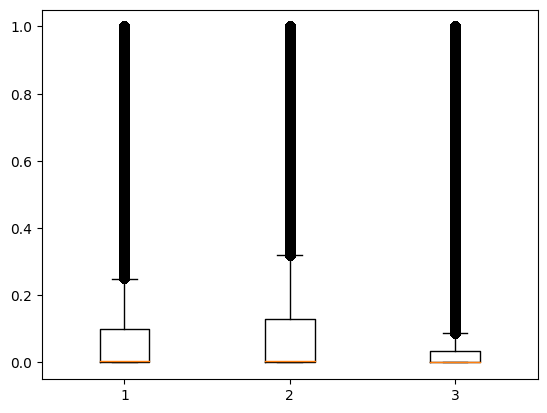

In [37]:
plt.boxplot(ont_cols)

In [47]:
%%time
calculate_metric(val_probs, vec_test_protein_ids, metric_gt, logs)

collecting metric:   0%|          | 0/28450 [00:00<?, ?it/s]

parsing preds:   0%|          | 0/8069066 [00:00<?, ?it/s]

In [48]:
logs

In [45]:
train_terms.loc[train_terms.EntryID.isin(train_protein_ids[train_index])]

,EntryID,term,aspect
90,A0A023FFD0,GO:0060302,BPO
91,A0A023FFD0,GO:0009968,BPO
92,A0A023FFD0,GO:0065007,BPO
93,A0A023FFD0,GO:0010648,BPO
94,A0A023FFD0,GO:0060300,BPO
...,...,...,...
5363840,X5KCU9,GO:0050649,MFO
5363841,X5KCU9,GO:0016491,MFO
5363860,X5M5N0,GO:0005515,MFO
5363861,X5M5N0,GO:0005488,MFO


In [26]:
metric_preds = []
val_trues, val_logits = [], []
            
tk1 = tqdm(
    dl_val, total=int(len(dl_val)), 
    desc="validating", ascii=True, leave=False, position=2)

for i, data in enumerate(tk1):
    data = {x : data[x].to(device) for x in list(data.keys())}
    with torch.no_grad() and torch.cuda.amp.autocast():
        batch = data['x'].shape[0]
        logits, loss = fold_model(data)
        logits = logits.detach().cpu().numpy()
        y_true = data['y']
        loss_val += loss.item() * batch
        val_trues.append(y_true.cpu().numpy())
        val_logits.append(logits)

val_logits = np.concatenate(val_logits, 0)
val_trues = np.concatenate(val_trues, 0)

validating:   0%|          | 0/6 [00:00<?, ?it/s]